In [17]:
import numpy as np
from matplotlib import pyplot as plt 

import skimage.io as io
from skimage import util
import skimage
from skimage.morphology import disk,white_tophat


from skimage.filters import laplace,sobel,gaussian
from skimage.filters.rank import gradient

from skimage.exposure import rescale_intensity,equalize_adapthist
from skimage import util
import skimage.morphology as morph

from scipy.signal import find_peaks
from matplotlib.patches import Rectangle
import seaborn as sns

import pandas as pd

from skimage.filters import threshold_otsu


from skimage import measure
import matplotlib

plt.style.use('default')
from skimage.feature import peak_local_max

In [18]:
def img_compare(img_dict):
    n_figures=len(img_dict)
    
    fig, ax = plt.subplots(1,n_figures,figsize=(5*n_figures, 5))
    counter=0
    for label in img_dict:
        img=img_dict[label]
        ax[counter].imshow(img[0:500,0:500])
        ax[counter].set_title(label)
        ax[counter].axis('off')
        counter=counter+1
        

# Primary object detection

## Image preparation

In [4]:
images=io.imread("../data/43125_Dark.tif")

# decrease noise
denoised=np.zeros_like(images,dtype="float32")
background=np.zeros_like(images,dtype="float32")
images_prepared=np.zeros_like(images,dtype="float32")
images_binary=np.zeros_like(images,dtype=np.ubyte)

for frame in range(5):
    print(frame)
    
    # denoised
    denoised[frame]=skimage.filters.gaussian(images[frame],1.5)
    
    # substract background
    background[frame]=skimage.filters.gaussian(images[frame],150)
    images_prepared[frame]=denoised[frame]-background[frame]
    
    #img_dict={"denoised":denoised[frame],"background":background[frame],"final_img":images_prepared[frame],"threshold":images_binary[frame]}
    img_dict={"filtered_img":images_prepared[frame],"threshold":images_binary[frame]}

0
1
2
3
4


## Outsu Threshold

In [5]:
# find common threshold across frames
Threshold=threshold_otsu(images_prepared)
images_binary[images_prepared>Threshold]=255
print(Threshold)

0.032199483


## Measure

In [6]:
total_result_df=pd.DataFrame()

for frame in range(5):
    label_image = measure.label(images_binary[frame])
    ## measurements
    props = measure.regionprops_table(label_image,images_prepared[frame],properties=
                                      ['label', 
                                       'centroid',
                                       'orientation',
                                       'major_axis_length',
                                       'minor_axis_length',
                                       'area',
                                       'perimeter',
                                       'eccentricity',
                                       'bbox',
                                       'max_intensity',
                                       'mean_intensity',
                                       'min_intensity'])
    result_df=pd.DataFrame(props)
    result_df["frame"]=frame
    result_df["compactness"]=result_df['perimeter']**2/result_df['area']
    result_df["circulaty"]=4*np.pi*result_df['area']/result_df['perimeter']**2
    #Michelson contrast
    result_df["contrast"]=(result_df['max_intensity']-result_df['min_intensity'])/(result_df['max_intensity']+result_df['min_intensity'])
    total_result_df=pd.concat([total_result_df,result_df])

total_result_df=total_result_df.reset_index()

### Filter objects

In [13]:
##===================================##
## filter object less than 5px in area
##===================================##
total_result_df=total_result_df[total_result_df['area']>25]


##================================##
# filter objects close to border
##================================##
total_result_df["boarder_flag"]=0
row,col=images[frame].shape

for i in total_result_df.index:
    t_row=int(total_result_df.loc[i]['centroid-0']-total_result_df.loc[i]['major_axis_length'])
    t_col=int(total_result_df.loc[i]['centroid-1']-total_result_df.loc[i]['major_axis_length'])

    if ((np.max([0,t_row])==0) or (np.min([row,t_row])==row)):
        total_result_df.loc[i,"boarder_flag"]=1.0
        #print(t_row,t_col)
        #print(total_result_df.loc[i,"boarder_flag"])
        
    if (np.max([0,t_col])==0) or (np.min([col,t_col]))==col:
        #print(t_row,t_col)
        total_result_df.loc[i,"boarder_flag"]=1.0
        #print(total_result_df.loc[i,"boarder_flag"])
        
        
total_result_df=total_result_df[total_result_df["boarder_flag"]==0]


(array([498.,  95.,  59.,  30.,  10.,  10.,   5.,   5.,   0.,   5.]),
 array([  26. ,  548.1, 1070.2, 1592.3, 2114.4, 2636.5, 3158.6, 3680.7,
        4202.8, 4724.9, 5247. ]),
 <BarContainer object of 10 artists>)

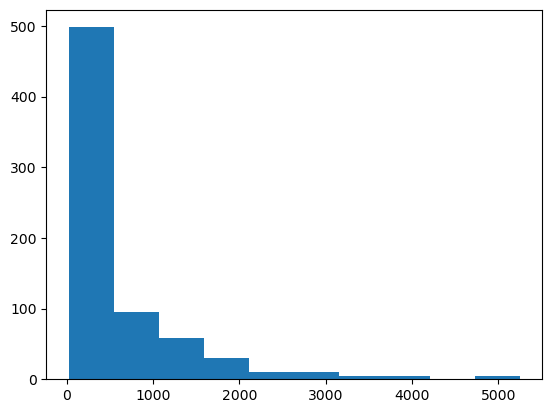

In [14]:
plt.hist(total_result_df["area"])

## Secondary objects

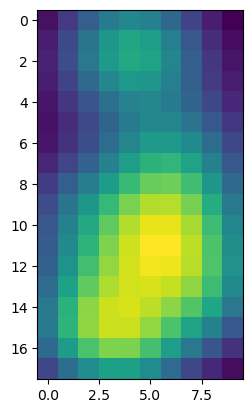

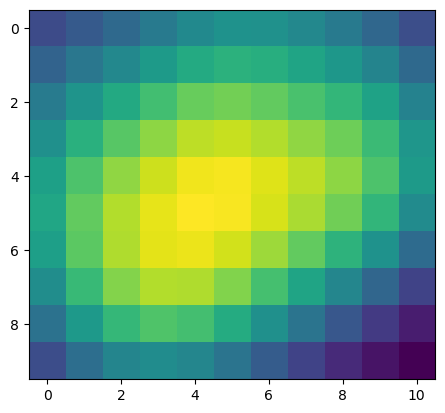

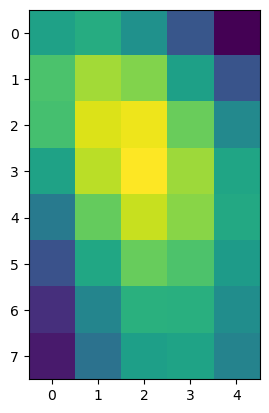

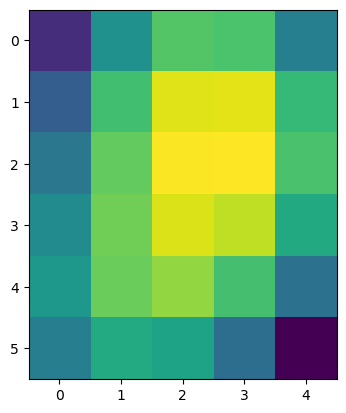

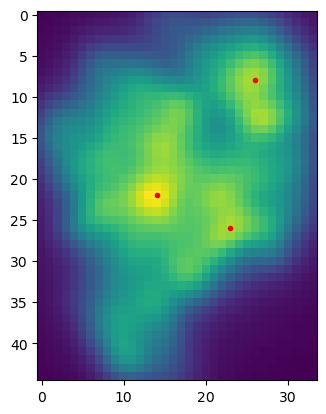

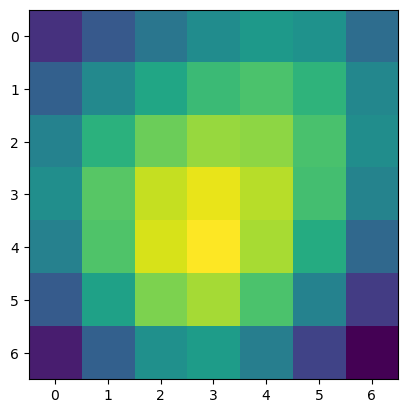

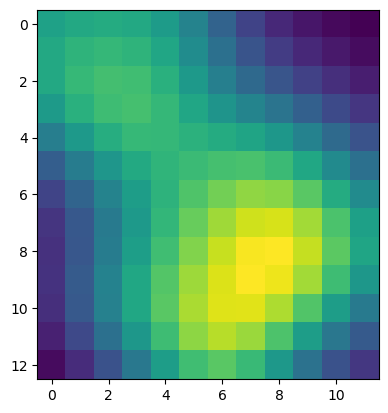

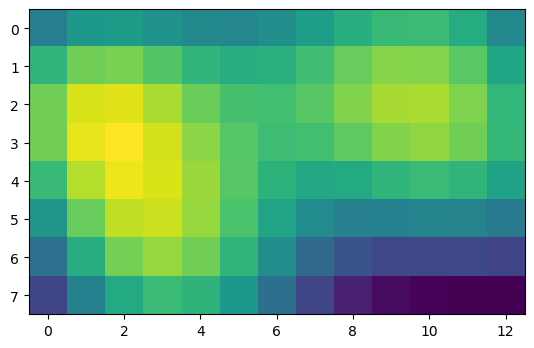

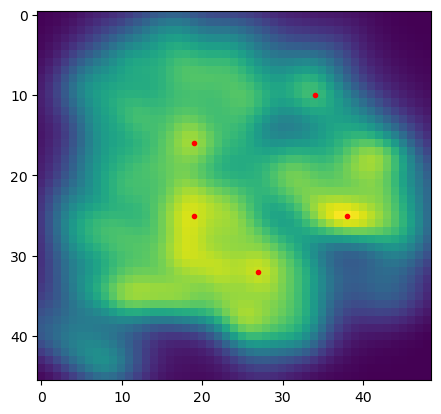

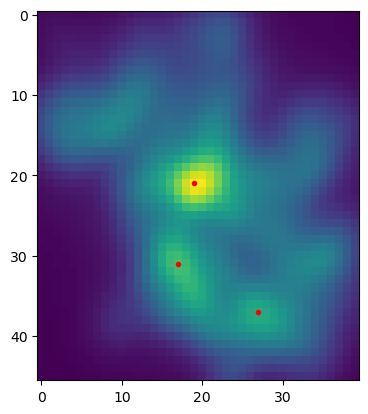

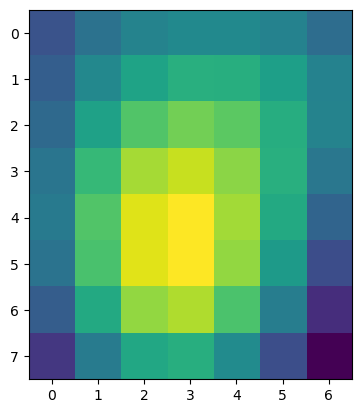

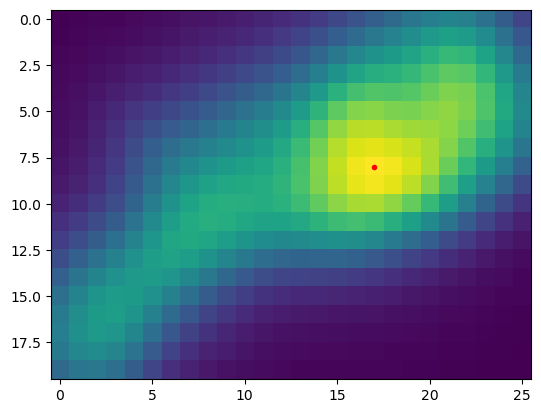

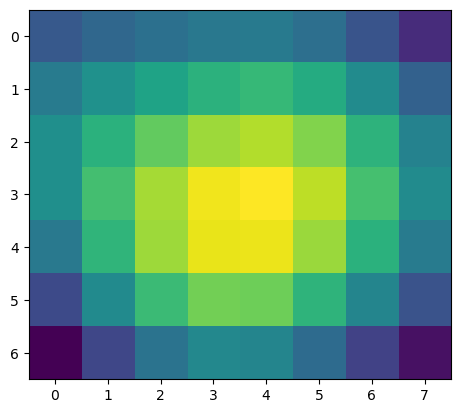

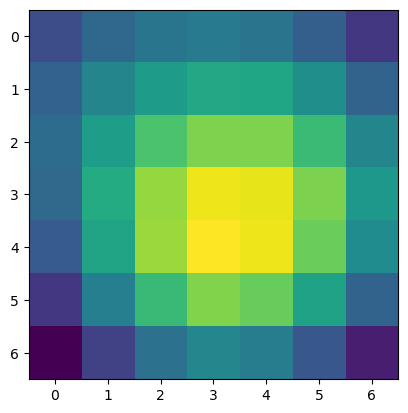

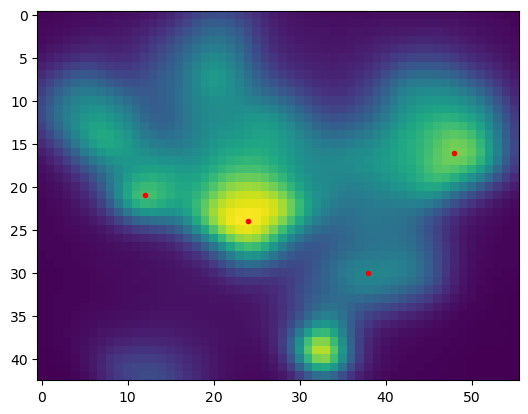

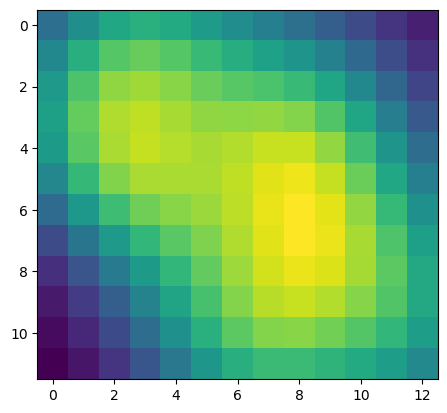

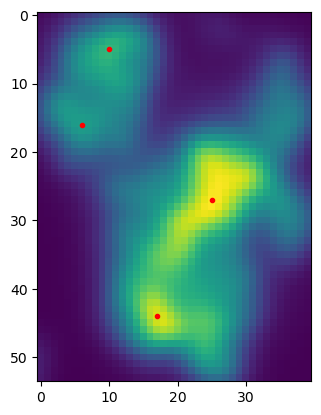

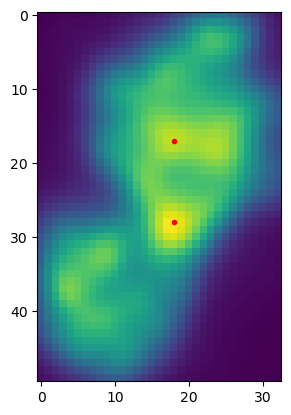

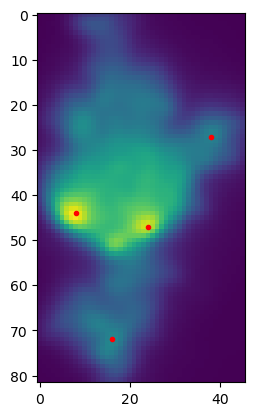

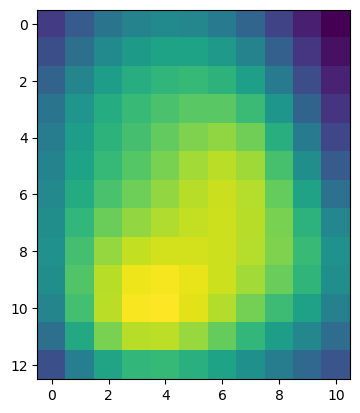

In [16]:
## local maximum
for id in total_result_df.index[:20]:
    frame=total_result_df.loc[id,'frame']
    props=total_result_df.loc[id,:]

    min_row,min_col,max_row,max_col=props.loc["bbox-0":"bbox-3"].values.astype(int)
    region=images_prepared[frame,min_row:max_row,min_col:max_col]
    
    plt.figure()
    plt.imshow(region)
    coordinates=peak_local_max(region, min_distance=5,threshold_abs=props.loc['min_intensity'])
    if (coordinates.size != 0.):
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    
    

## Viz results

In [188]:
def plot_one_entity(img,segmented,props):
    f = plt.figure(figsize=(10,3))
    ax_img = f.add_subplot(161)
    ax_region_ext = f.add_subplot(162)
    ax_region_ext_seg = f.add_subplot(163)
    ax_label = f.add_subplot(164)
    
    # ax_img
    ax_img.imshow(img,cmap="gray")
    min_row,min_col,max_row,max_col=props.loc["bbox-0":"bbox-3"].values.astype(int)
    rect =matplotlib.patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,fill=False, edgecolor='red', linewidth=3)
    ax_img.add_patch(rect)
    ax_img.axis("off")
    ax_img.set_title(str(props.loc["label"]))
    ax_img.axis("off")
 
    # ax_region_ext
    delta=7
    min_row_ext=np.max([0,min_row-delta])
    max_row_ext=max_row+delta
    min_col_ext=np.max([0,min_col-delta])
    max_col_ext=max_col+delta
    ax_region_ext.imshow(img[min_row_ext:max_row_ext,min_col_ext:max_col_ext],cmap="gray")
    ax_region_ext.axis("off")
    
    # ax_segment
    ax_region_ext_seg.imshow(segmented[min_row_ext:max_row_ext,min_col_ext:max_col_ext],cmap="gray")
    ax_region_ext_seg.axis("off")
    
    #attributes
    attributes_intenisty="frame={:.2f}    mean_intensity={:.2f}   contrast={:.2f} \n".format(props['frame'],props['mean_intensity'],props["contrast"])
    attributes_geometry="minor={:.2f}   major={:.2f}  \n".format(props["minor_axis_length"],props["major_axis_length"])
    attributes_shape="area={:.2f}   eccentricity={:.2f}   \n".format(props["area"],props["eccentricity"])
    attributes=attributes_intenisty+attributes_geometry+attributes_shape                                                                                                
    ax_label.text(0,0.5,attributes)
    ax_label.axis("off")
    
    
    #plt.tight_layout()

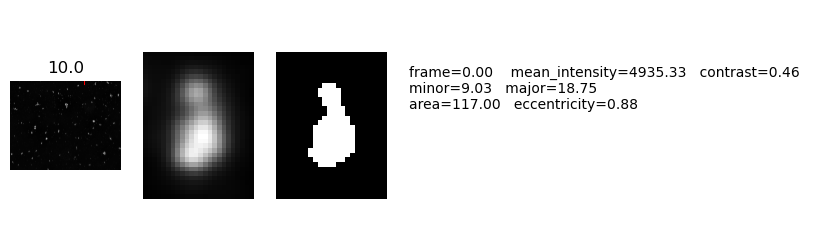

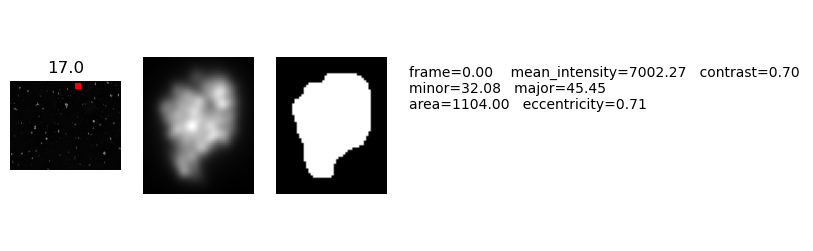

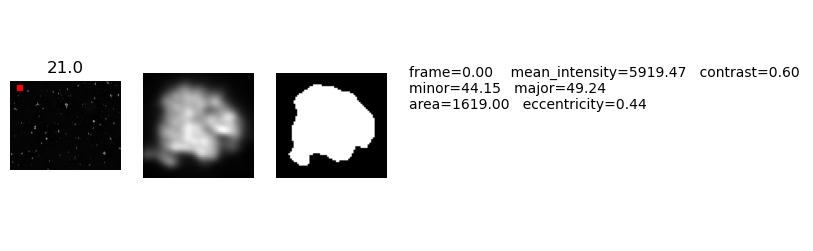

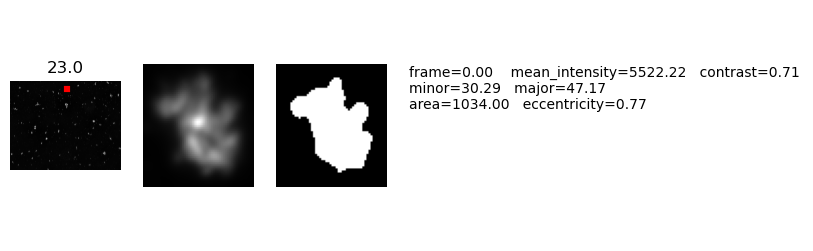

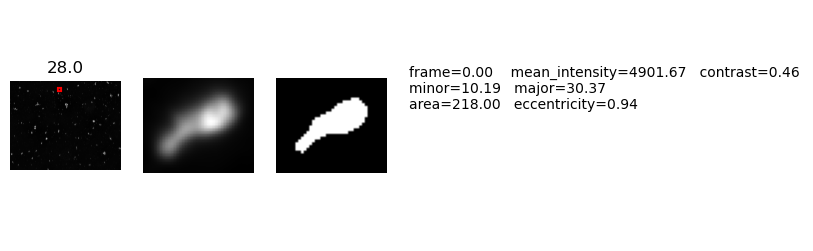

In [195]:
Selection=total_result_df[total_result_df["area"]>100]

for id in Selection.index[:5]:
    frame=Selection.loc[id,'frame']
    plot_one_entity(images_prepared[frame],images_binary[frame],Selection.loc[id,:])
   


In [31]:
io.imsave("../data/43125_Dark_denoised.tif",util.img_as_ubyte(denoised))
io.imsave("../data/43125_Dark_bg.tif",util.img_as_ubyte(background))
io.imsave("../data/43125_Dark_images_prepared.tif",util.img_as_ubyte(images_prepared))
io.imsave("../data/43125_Dark_images_binary.tif",images_binary)

/Users/pichugina/anaconda3/envs/omeropy/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: ../data/43125_Dark_denoised.tif is a low contrast image
  """Entry point for launching an IPython kernel.
/Users/pichugina/anaconda3/envs/omeropy/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: ../data/43125_Dark_bg.tif is a low contrast image
  
/Users/pichugina/anaconda3/envs/omeropy/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: ../data/43125_Dark_images_prepared.tif is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


# Secondary object detection

# Segmentation secondary object

In [141]:
watershed_img=1-denoised
watershed_img=watershed_img-np.min(watershed_img)

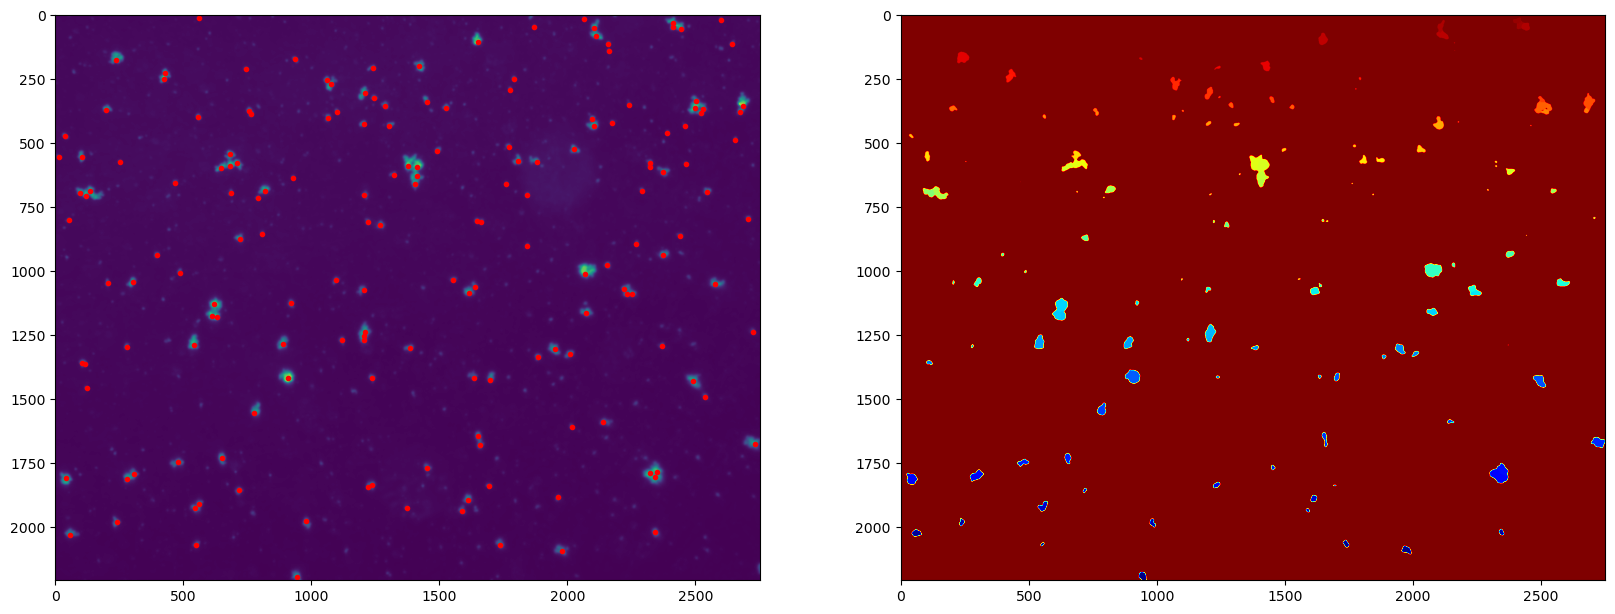

In [161]:
# markers
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

coordinates=peak_local_max(denoised, min_distance=10,threshold_rel=0.25)
maxima_image=np.zeros_like(img_test)
maxima_image[coordinates[:, 0], coordinates[:, 1]]=1

labeled_maxima, object_count = ndi.label(maxima_image, np.ones((3, 3), bool))
markers = np.zeros(watershed_img.shape, np.int32)
markers[labeled_maxima > 0] = -labeled_maxima[labeled_maxima > 0]

watershed_boundaries = segmentation.watershed(
                connectivity=np.ones((3, 3), bool),
                image=watershed_img,
                markers=markers,
                mask=labeled_image != 0)



fig,ax= plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax[0].imshow(img_test)
ax[0].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].imshow(watershed_boundaries,cmap=plt.cm.jet)

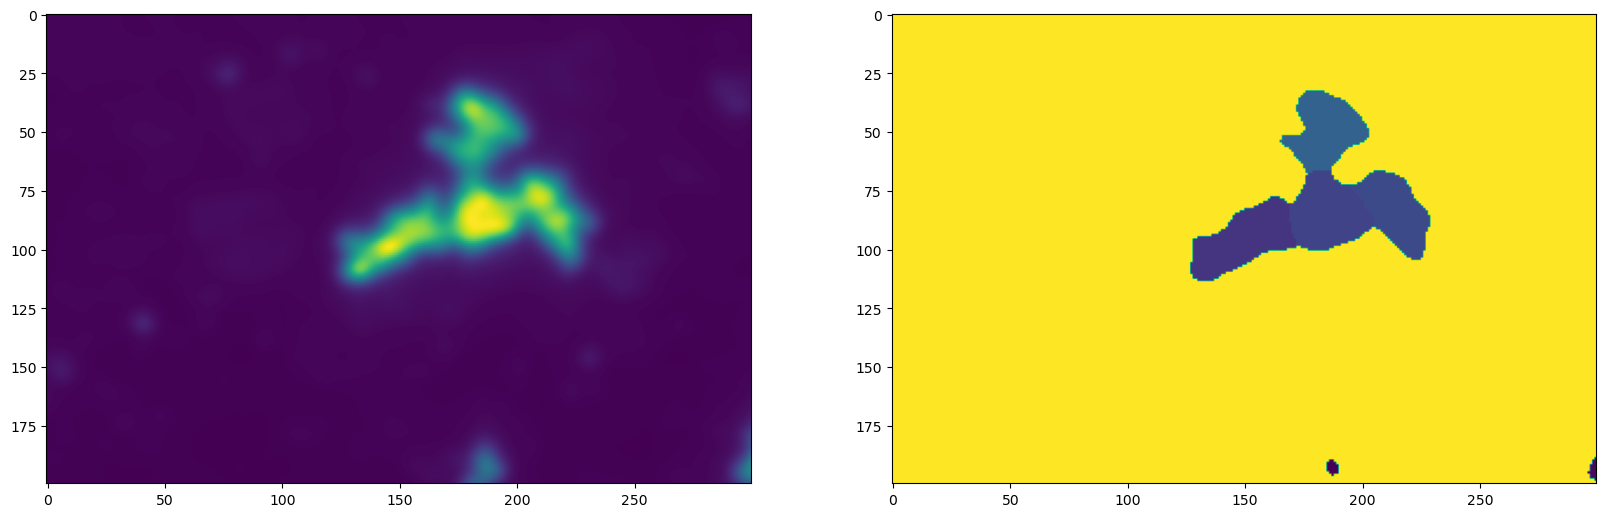

In [162]:
fig,ax= plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax[0].imshow(img_test[500:700,500:800])
#ax[0].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].imshow(watershed_boundaries[500:700,500:800])